In [10]:
%matplotlib inline
import os

import numpy as np
from matplotlib import pyplot as plt

In [2]:
chains = []

In [3]:
!ls /pscratch/sd/u/uendert/

blinding_mocks	test_y1_bao  test_y1_full_shape


In [4]:
from desilike.samples import plotting, Chain

# desilike
chains = []

chain_dir = os.path.join(os.getenv('SCRATCH'), 'test_y1_full_shape')
tracers = ['LRG']
#tracers = ['LRG']
chain = Chain.concatenate([Chain.load(os.path.join(chain_dir, 'chain_{}_0.4_0.6_corr_velocileptors_shapefit_{:d}.npy'.format('_'.join(tracers), i))).remove_burnin(0.5)[::20] for i in range(8)])
chain = chain.sample_solved()
# chain['H0'] = 100 * chain['h']
#chain['H0'].param.update(latex='H_{0}', prior=dict(limits=[1., 100.]))
# param = chain['H0'].param
# param.update(latex='H_{0}', prior=param.prior.affine_transform(loc=99. * param.prior.center(), scale=100.))
chains.append(chain.to_getdist(label='desilike'))
#chain = Chain.concatenate([Chain.load(os.path.join(chain_dir, 'chain_{}_x10_{:d}.npy'.format('_'.join(tracers), i))).remove_burnin(0.5)[::20] for i in range(8)])
#chains.append(chain.to_getdist(label='desilike x10'))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Removed no burn in


In [5]:
print(chains)

In [6]:
temp = chains[0]
-2 * temp.loglikes.max()

-80.06965668383722

<Figure size 640x480 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 2400x2400 with 0 Axes>

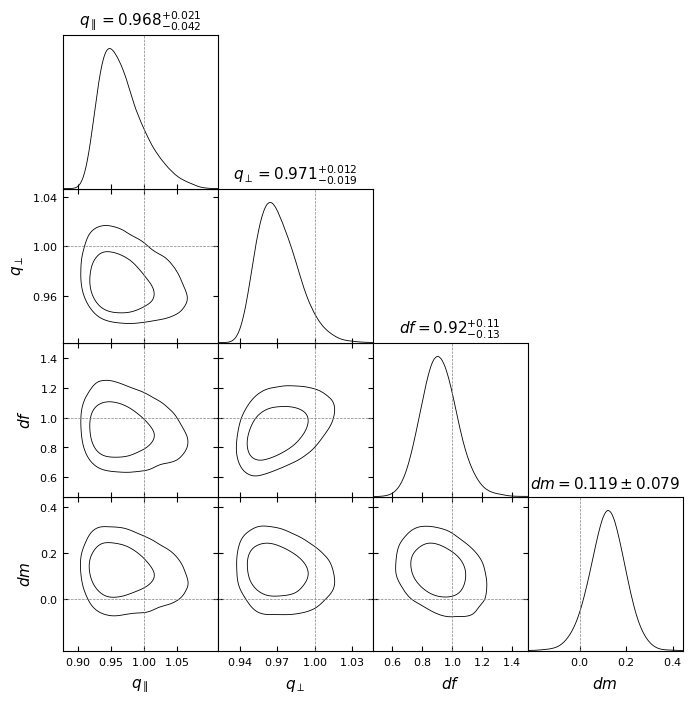

In [11]:
from getdist import plots
plt.clf()
g = plots.get_subplot_plotter()
g.settings.alpha_filled_add=0.4
g.settings.title_limit_fontsize = 14
g.triangle_plot(chains, params=["qpar", "qper", "df", "dm"], analysis_settings={'ignore_rows': 0.2}, title_limit=1,
                markers={"qpar":1., "qper":1., "df":1., "dm":0.},
                filled=False)
plt.show()

<Figure size 640x480 with 0 Axes>

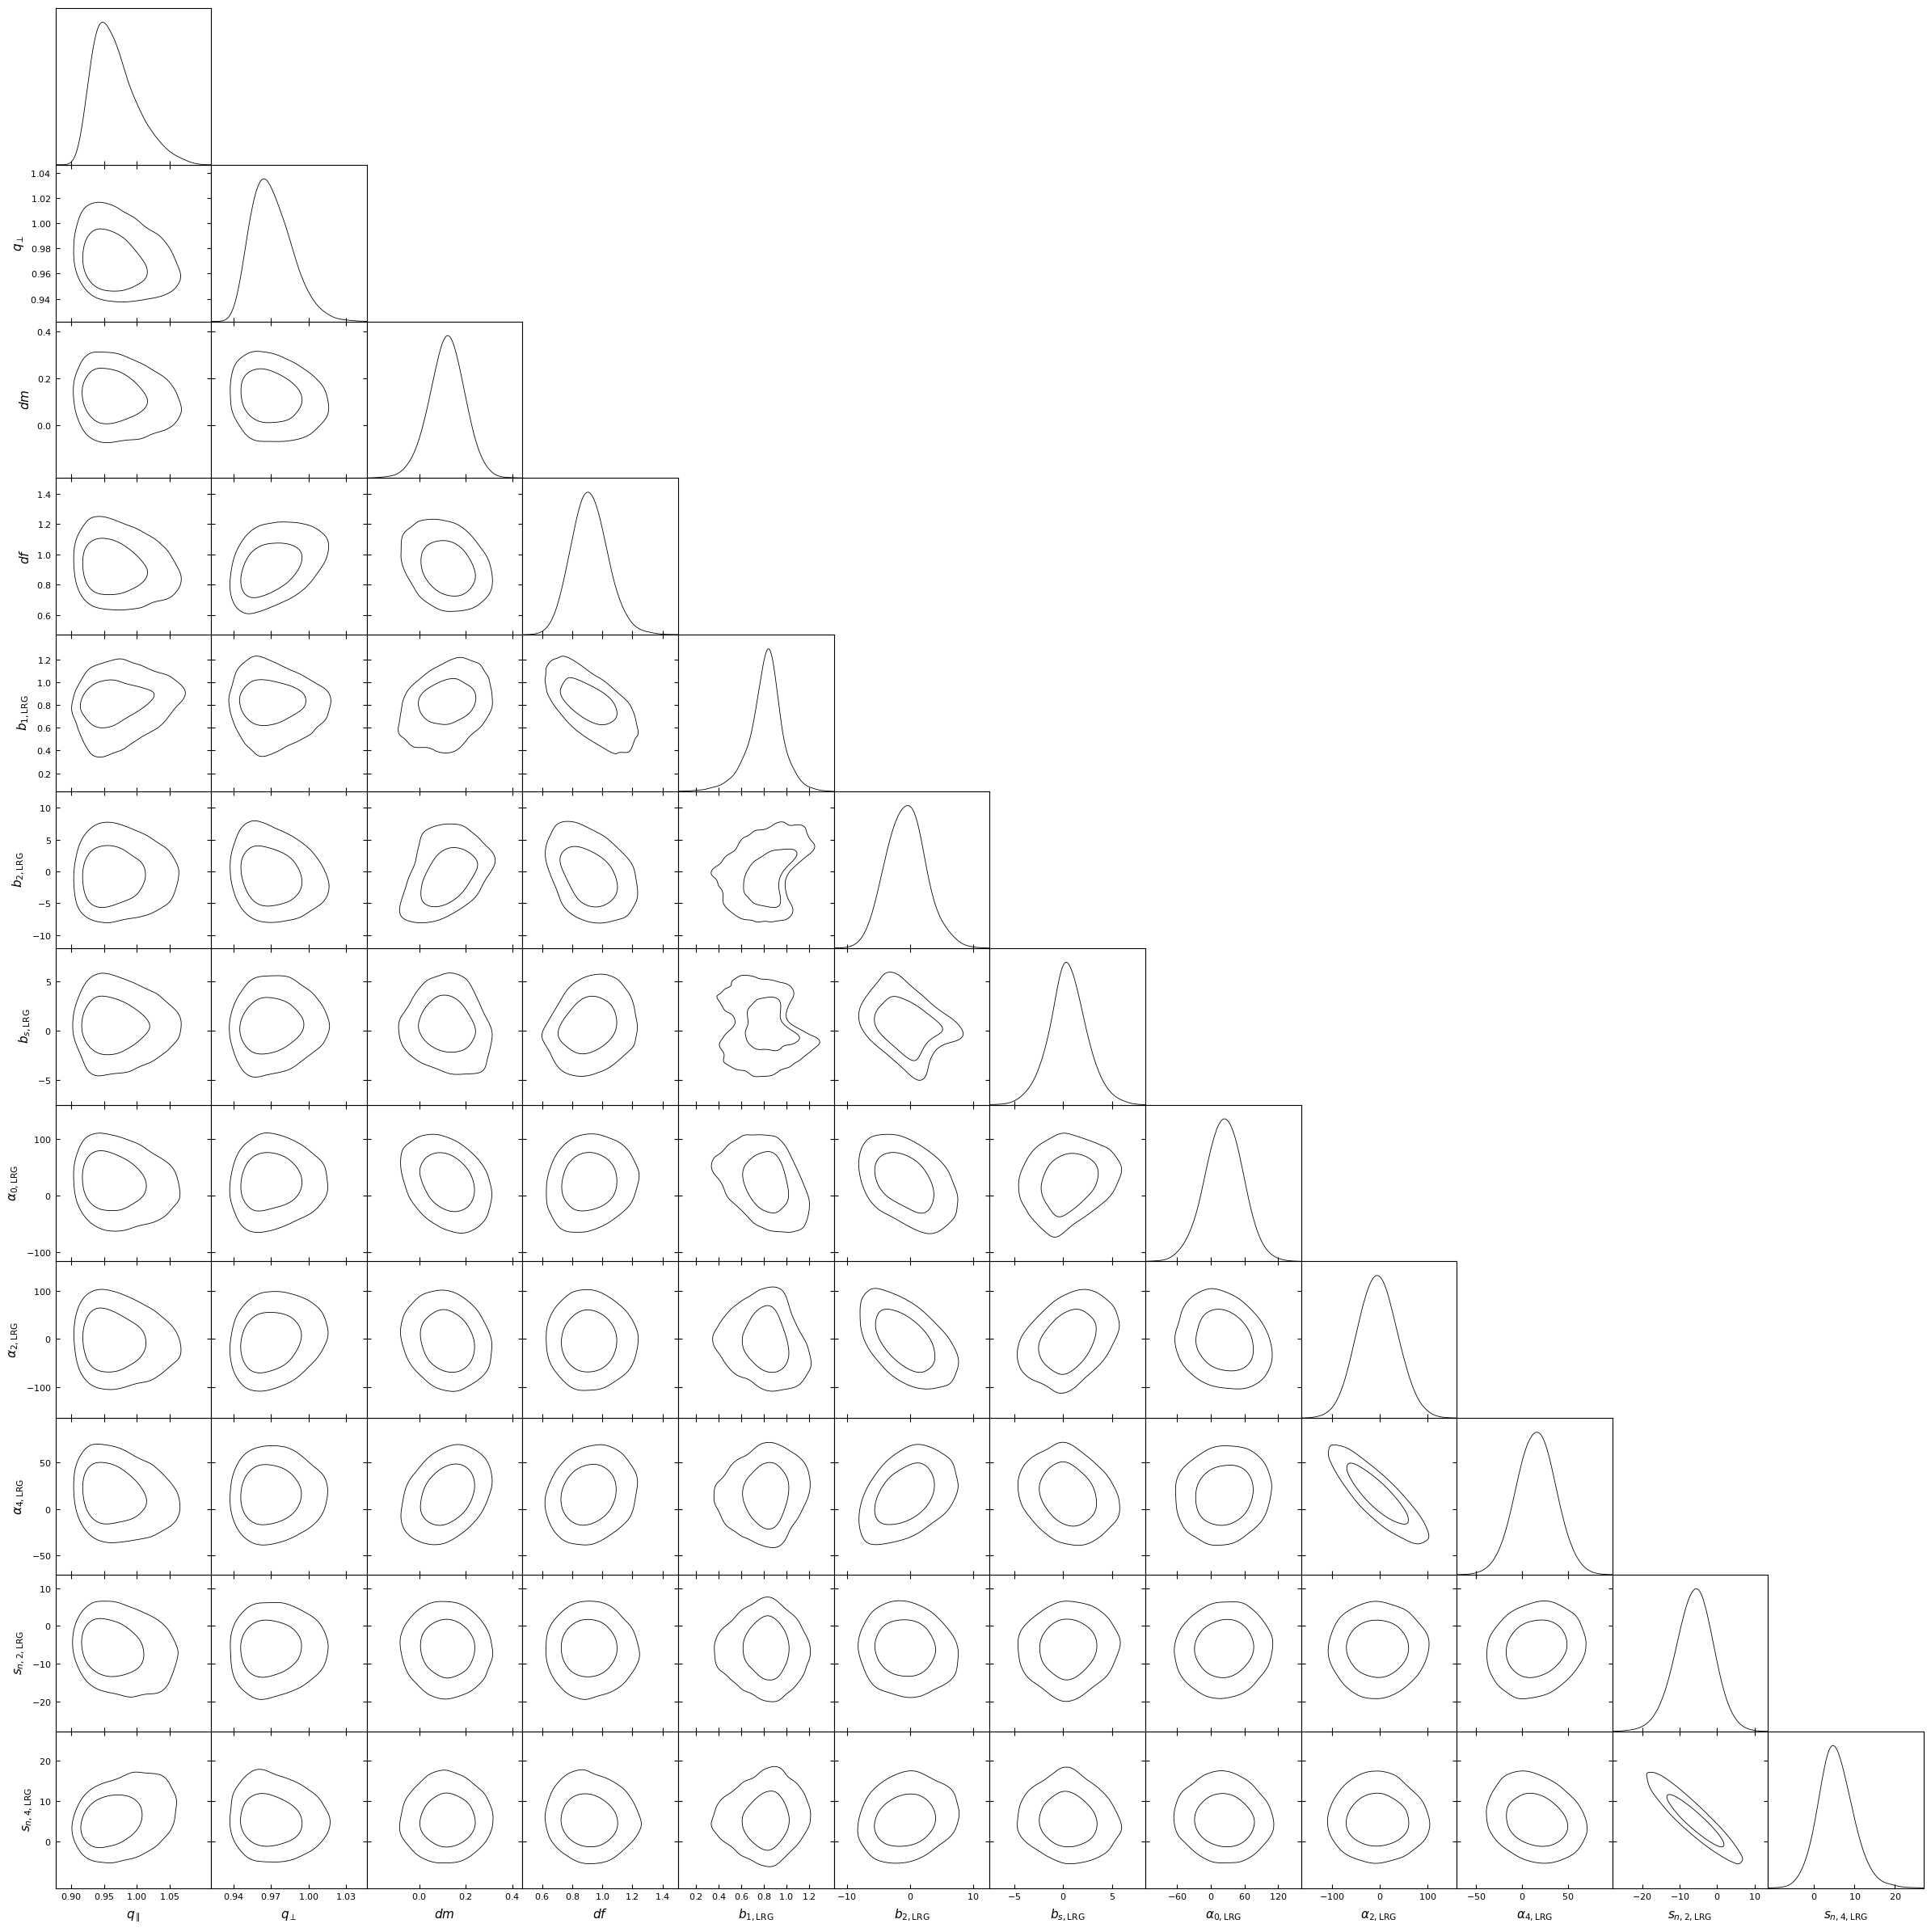

In [12]:
from getdist import plots
plt.clf()
g = plots.get_subplot_plotter()
g.triangle_plot(chains)
plt.show()

In [9]:
print(chains[-1].getTable().tableTex())

\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$q_{\parallel}  $} & $0.968^{+0.071}_{-0.056}   $\\

{\boldmath$q_{\perp}      $} & $0.971^{+0.033}_{-0.029}   $\\

{\boldmath$dm             $} & $0.12^{+0.15}_{-0.16}      $\\

{\boldmath$df             $} & $0.92^{+0.26}_{-0.23}      $\\

{\boldmath$b_{1, \mathrm{LRG}}$} & $0.81^{+0.29}_{-0.36}      $\\

{\boldmath$b_{2, \mathrm{LRG}}$} & $-0.6^{+6.7}_{-5.9}        $\\

{\boldmath$b_{s, \mathrm{LRG}}$} & $0.5^{+4.1}_{-4.0}         $\\

{\boldmath$\alpha_{0, \mathrm{LRG}}$} & $23^{+70}_{-70}            $\\

{\boldmath$\alpha_{2, \mathrm{LRG}}$} & $-5^{+83}_{-81}            $\\

{\boldmath$\alpha_{4, \mathrm{LRG}}$} & $15^{+43}_{-43}            $\\

{\boldmath$s_{n, 2, \mathrm{LRG}}$} & $-6.1^{+9.9}_{-11}         $\\

{\boldmath$s_{n, 4, \mathrm{LRG}}$} & $5.5^{+9.7}_{-8.4}         $\\
\hline
\end{tabular}
